# <font color='black'>EE25737: Introduction to Machine Learning</font>
## <font color='black'>Fall 1400-01, Group 2</font>
## Computer Assignment 3

### Student Name: Amirmehdi Jafari Fesharaki
### Student ID: 98109645

## A. Spline 

Recorded data in a study done to recognize the human activity, exploiting an accelerometer sensor of a smartwatch has been given.
In this problem, we want to use cubic splines to smooth (denoise) two given time sequences that contain a high amount of noise. The sampling frequency of the given data is 90 Hz, and the duration of each sequence is 10 seconds.

First, load the data and plot each one of the two given time sequences.

#### Importing Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
df = pd.read_excel('./data.xlsx')
df = df.rename({'Unnamed: 0': '#Sample'}, axis='columns')
df.head()

,#Sample,Running,Walking
0,0,1.519721,-0.665810
1,1,1.808666,-0.893857
2,2,1.581995,-0.127671
3,3,1.754156,-0.391311
4,4,1.620189,-0.501031


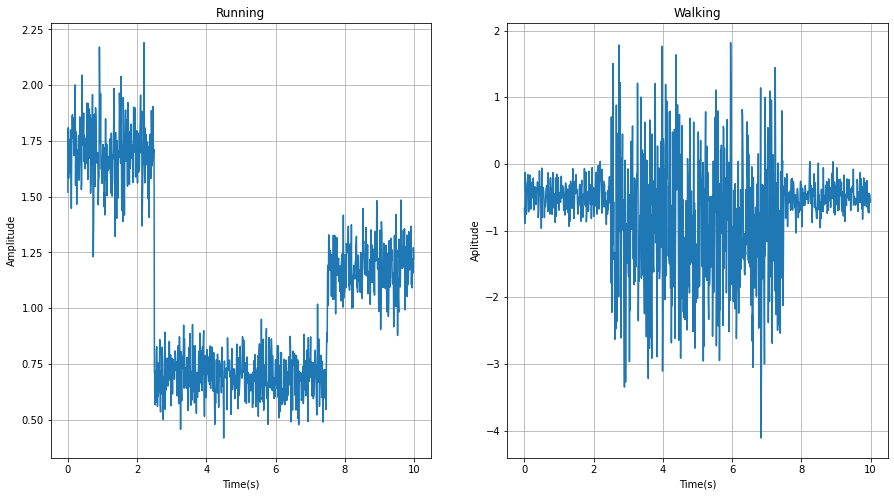

In [3]:
arr = df.to_numpy()
time = arr[:,0] * 1/90
running = arr[:,1]
walking = arr[:,2]
fig = plt.figure(figsize=(15,8))

## plotting
# Running
plt.subplot(1,2,1)
plt.plot(time, running)
plt.title('Running')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.grid()

# Walking
plt.subplot(1,2,2)
plt.plot(time, walking)
plt.title('Walking')
plt.xlabel('Time(s)')
plt.ylabel('Aplitude')
plt.grid()

For each given time sequence, generate cubic splines with two different numbers of knots (you may try with 40 and 200 knots), then plot the raw data and the two splines on the same figure.

In [4]:
class CubicSplineModel:
    '''This class is creates a cubic spline model for a given dataset'''
    def __init__(self, x, y, knots):
        self.x_train = x
        self.y_train = y
        self.knots = knots
    
    def fill_parameters(self, x, knots):
        '''This method creates an array X which contains the parameters 1,x,x^2,x^3,(x-csi1)^3, .... for each data
           the array X is then used in a simple linear regression model'''
        x_min = min(x)
        x_max = max(x)
        csi_step = (x_max - x_min)/(knots + 1)
        csi_arr = np.arange(x_min + csi_step, x_max, csi_step)
        
        const = np.ones((len(x), 1))
        x_arr = x
        x2_arr = x_arr**2
        x3_arr = x_arr**3
        X = const.copy()
        X = np.append(X, np.array([x_arr]).T, axis = 1)
        X = np.append(X, np.array([x2_arr]).T, axis = 1)
        X = np.append(X, np.array([x3_arr]).T, axis = 1)
        for csi in csi_arr:
            x_csi = (x_arr - csi)**3
            x_csi[x_arr<csi] = 0
            X = np.append(X, np.array([x_csi]).T, axis = 1)
        return X
    
    def fit(self):
        X_train = self.fill_parameters(self.x_train, self.knots)
        self.model = LinearRegression().fit(X_train, self.y_train)
    
    def predict(self, x_test):
        X_test = self.fill_parameters(x_test, self.knots)
        y_pred = self.model.predict(X_test)
        return y_pred
    
    def result_plotter(self, title = '', xlabel = 'Time(s)', ylabel = 'Amplitude'):
        self.fit()
        x = self.x_train
        y = self.y_train
        knots = self.knots
        y_pred = self.predict(x)
        self.y_pred = y_pred
        ##Plotting the result
        plt.figure(figsize=(15,8))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.plot(x, y, 'darkorange')
        plt.plot(x, y_pred, 'dodgerblue')
        plt.legend(['True', 'Smoothed'])
        plt.grid()

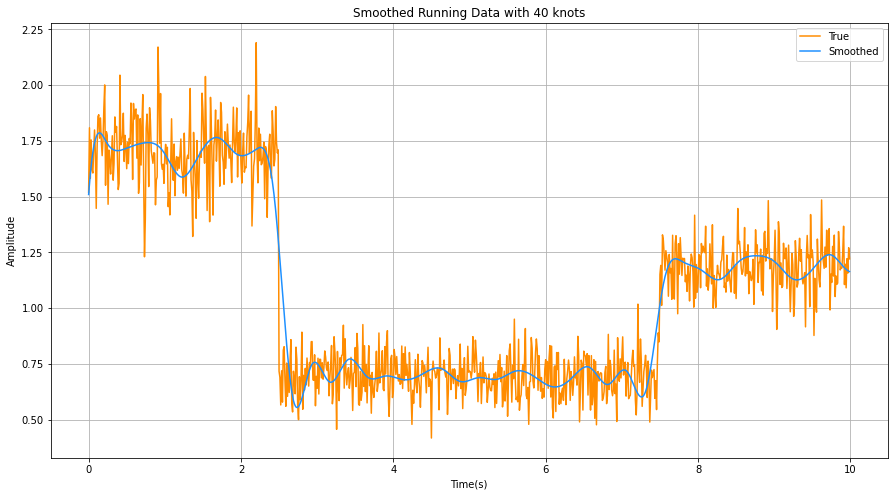

In [5]:
model40_run = CubicSplineModel(time, running, 40)
model40_run.result_plotter('Smoothed Running Data with 40 knots')

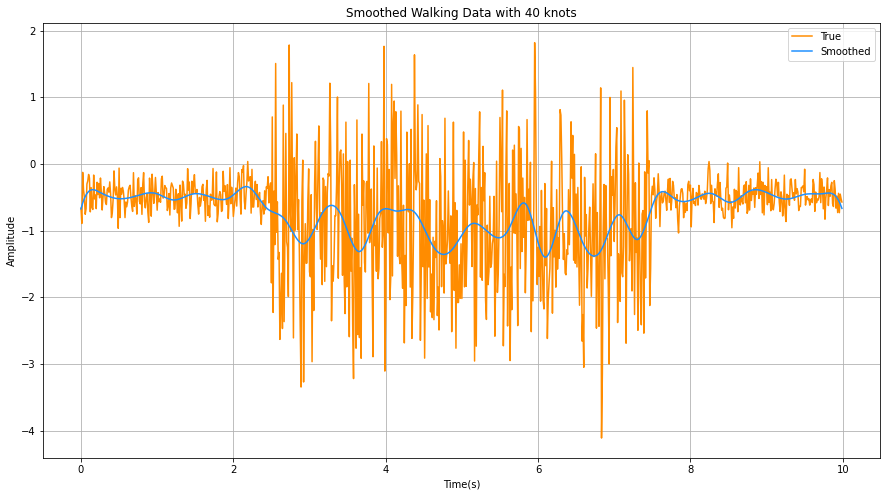

In [6]:
model40_walk = CubicSplineModel(time, walking, 40)
model40_walk.result_plotter('Smoothed Walking Data with 40 knots')

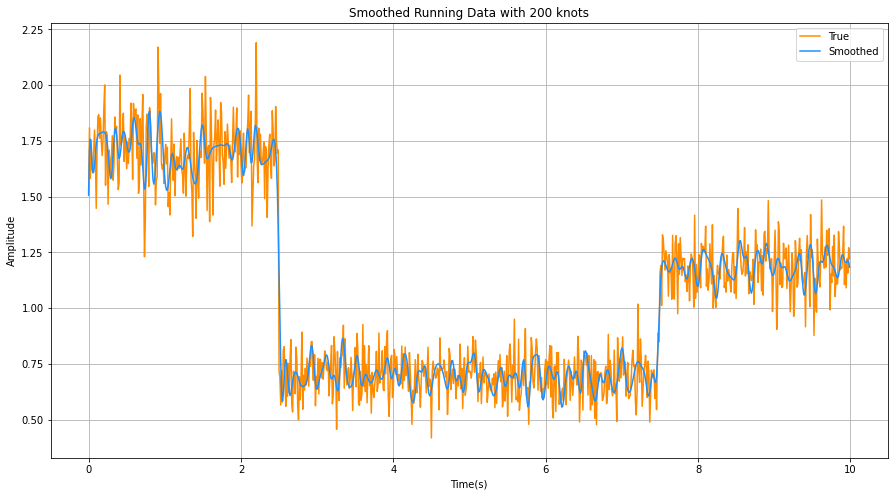

In [7]:
model200_run = CubicSplineModel(time, running, 200)
model200_run.result_plotter('Smoothed Running Data with 200 knots')

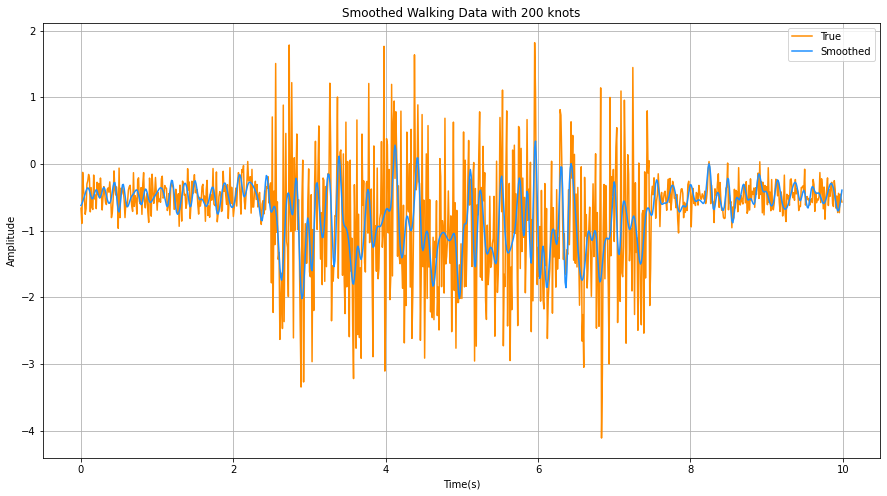

In [8]:
model200_walk = CubicSplineModel(time, walking, 200)
model200_walk.result_plotter('Smoothed Walking Data with 200 knots')

Explain your inference from the effect of changing the number of knots on the final spline figure.

<b>From the plots we can find out that as the number of knots increases, the cubic spline model fits the data more accurately. However, the whole purpose of using cubic spline in this problem was to find a smoother curve that fits the given data and rejects the noise. By increasing the number of knots, this noise is less likely to be rejected. As a result, the best choice for the number of knots is the one which keeps the whole trend and rejects the noise simultaniously. In this particular case, 40 knots could be a good choice in comparison with 200 knots.</b>

# B. SVM and Cross-validation


# B.1 KNN

Load the digits dataset from sklearn.datasets package; consider the first 30 percent of the data for testing and the rest for training.
First, we aim to tune the KNN classifier using the cross-validation method. To do so, consider a set of values for K. Then, by enlisting cross-validation, find the optimal K and report its corresponding validation error. By using the optimal K and the entire training set, classify the test data and calculate the classification error. Do not use built-in function for implementing KNN.

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [10]:
class KNNModel:
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
    
    def predict(self, X_test, Y_test, k_nn):
        X_train = self.X_train
        Y_train = self.Y_train
        Y_pred = np.array([])
        for x_test in X_test:
            dist = np.linalg.norm(X_train - x_test, axis = 1)
            
            ## sorting and selecting K-NN data
            ind = np.argsort( dist)
            Y_sorted = np.take_along_axis(Y_train, ind, axis=0)
            Y_knn = Y_sorted[0:k_nn]
            
            ## finding the nearest neighbor
            vote = np.zeros(10)
            for i in range(0,10):
                vote[i] = len(Y_knn[Y_knn == i])
            y_pred = np.argmax(vote)
            Y_pred = np.append(Y_pred, y_pred)
        return Y_pred
    
    def reporter(self, X_test, Y_test, k_nn):
        Y_pred = self.predict(X_test, Y_test, k_nn)
        corrects = np.zeros(len(Y_test))
        corrects[Y_pred == Y_test] = 1
        acc = len(corrects[corrects==1])/len(corrects)
        return Y_pred, acc

In [11]:
class KNN_CV_Model:
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    def knn_acc_calculator(self, k, n_splits = 5):
        '''Finds the accuracy for a given k (number of nearest neighbors) using CV'''
        X = self.X_train
        Y = self.Y_train
        kf = KFold(n_splits = n_splits)
        acc_list = np.array([])
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            model = KNNModel(X_train, Y_train)
            Y_pred, acc = model.reporter(X_test, Y_test, k)
            acc_list = np.append(acc_list, acc)
        acc = np.mean(acc_list)
        return acc, acc_list
    
    def find_optimal_k(self, n_splits = 5):
        '''Finds the k(number of nearest neighbors) with the maximum accuracy. In this process
        k varies from 1 to 20.'''
        # finding the optimal k for k between 1 to 20
        acc_list = np.array([])
        for k in range(1,21):
            acc, _ = self.knn_acc_calculator(k, n_splits)
            acc_list = np.append(acc_list, acc)
        k_optimal = np.argmax(acc_list) + 1
        return k_optimal, acc_list

In [12]:
digits = load_digits()
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size = 0.3, shuffle=True)

## KNN with CV for a large dataset

In [13]:
cv_model = KNN_CV_Model(X_train, Y_train)
k_optimal, acc_list = cv_model.find_optimal_k()

In [14]:
print('The KNN has the maximum accuracy when k is', k_optimal)

The KNN has the maximum accuracy when k is 1


In [15]:
print('Accuracy list for the large dataset:')
print(acc_list)

Accuracy list for the large dataset:
[0.98488902 0.98011446 0.98171125 0.97773351 0.97852716 0.97534307
 0.97773035 0.97454626 0.97454942 0.97136849 0.97216531 0.96977803
 0.96659394 0.9642035  0.96420667 0.9610289  0.95943527 0.95783849
 0.95863214 0.95784165]


In [16]:
## now we classify the test data and calculate the classification error
knn_model = KNNModel(X_train, Y_train)
Y_pred, knn_acc = knn_model.reporter(X_test, Y_test, k_optimal)
print('The accuracy of the KNN on the entire training set is:', knn_acc)

The accuracy of the KNN on the entire training set is: 0.9851851851851852


By enlisting the Confusion Matrix, measure the performance of classifiers above for each of the classes.

In [17]:
confusion_matrix(Y_test, Y_pred, labels = [0,1,2,3,4,5,6,7,8,9])

array([[49,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 57,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 61,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 55,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 57,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 59,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 46,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 54,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  0, 46,  0],
       [ 0,  1,  0,  1,  0,  2,  0,  0,  1, 48]])

As it can be understood from the confusion matrix, for almost all of the digits, we have an accuracy of 100% except for 3, 5, 8 and 9 which were predicted as another digit in some cases. However, the results are still satisfying and the model works perfectly.

Now consider a relatively small set of training data and repeat previous sections with this new set.

In [18]:
## In this part, we use only 10 percent of the training set (with the same test set)
X_train_s = X_train[0:int(len(X_train)/10)]
Y_train_s = Y_train[0:int(len(Y_train)/10)]

cv_model_s = KNN_CV_Model(X_train_s, Y_train_s)
k_optimal_s, acc_list_s = cv_model_s.find_optimal_k()
print('The KNN has the maximum accuracy when k is', k_optimal_s)

The KNN has the maximum accuracy when k is 1


In [19]:
print('Accuracy list for the smaller dataset:')
print(acc_list_s)

Accuracy list for the smaller dataset:
[0.896 0.872 0.888 0.848 0.856 0.848 0.832 0.808 0.784 0.744 0.752 0.752
 0.712 0.688 0.68  0.672 0.624 0.616 0.608 0.608]


As it is shown, the accuracies had a noticable decrease for the smaller training set. The interesting point is that k=1 still has the highest accuracy.

In [20]:
## now we classify the test data and calculate the classification error
knn_model_s = KNNModel(X_train_s, Y_train_s)
Y_pred_s, knn_acc_s = knn_model_s.reporter(X_test, Y_test, k_optimal_s)
print('The accuracy of the KNN on the entire training set is:', knn_acc_s)

The accuracy of the KNN on the entire training set is: 0.9203703703703704


In [21]:
confusion_matrix(Y_test, Y_pred_s, labels = [0,1,2,3,4,5,6,7,8,9])

array([[48,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 49,  5,  0,  2,  0,  1,  0,  0,  0],
       [ 0,  0, 57,  1,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  1, 48,  0,  0,  0,  0,  6,  1],
       [ 0,  0,  0,  0, 55,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0, 53,  0,  1,  0,  6],
       [ 0,  0,  0,  0,  0,  0, 46,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0,  0, 51,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  1,  0, 45,  0],
       [ 1,  1,  0,  1,  0,  0,  0,  0,  5, 45]])

# B.2 SVM

In this section, again consider the entire digits training set. Use soft margin linear SVM to do the multiple class classification based on one-vs-one and one-vs-all approaches. In either method, apply suitable cross-validation for choosing the best C parameter. Compare the test error of the two methods. (choose C among a predefined set of 5 values)

In [110]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity

In [102]:
class SVMModel:
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        
    def find_accuracy(self, X_test, Y_test,  kernel, C, gamma = 'auto', func_shape = 'both'):
        '''Finds the accuracy for a given dataset with a given C and kernel and returns the accuracy of it
        for both one-vs-one and one-vs-all approaches'''
        
        svm_one = SVC(C = C, kernel = kernel, gamma = gamma, decision_function_shape ='ovo').fit(self.X_train, self.Y_train)
        svm_all = SVC(C = C, kernel = kernel, gamma = gamma, decision_function_shape ='ovr').fit(self.X_train, self.Y_train)
        
        acc_one = svm_one.score(X_test, Y_test)
        acc_all = svm_all.score(X_test, Y_test)
        if (func_shape == 'both'):
            return acc_one, acc_all
        elif(func_shape == 'one'):
            return acc_one
        elif(func_shape == 'all'):
            return acc_all
        else:
            return None

In [124]:
class SVM_CV:
    def __init__(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
    
    def acc_calc(self, kernel, C, gamma = 'auto', n_splits = 5):
        '''Finds the accuracy for a given kernel, C and gamma(if needed) using CV'''
        X = self.X_train
        Y = self.Y_train
        kf = KFold(n_splits = n_splits)
        acc_one_list = np.array([])
        acc_all_list = np.array([])
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            model = SVMModel(X_train, Y_train)
            acc_one, acc_all = model.find_accuracy(X_test, Y_test, kernel, C, gamma)
            acc_one_list = np.append(acc_one_list, acc_one)
            acc_all_list = np.append(acc_all_list, acc_all)
        acc_one = np.mean(acc_one_list)
        acc_all = np.mean(acc_all_list)
        return acc_one, acc_all
    
    def find_optimal(self, kernel, C_list, gamma_list = ['auto'], has_gamma = False, n_splits = 5):
        '''Finds the optimal values for C and gamma(if given) that gives the highest accuracy after cross-validation.
        The optimal values are found in a given list for them.'''
        acc_one_list = np.zeros((len(C_list), len(gamma_list)))
        acc_all_list = np.zeros((len(C_list), len(gamma_list)))
        for i in range(len(C_list)):
            C = C_list[i]
            for j in range(len(gamma_list)):
                gamma = gamma_list[j]
                acc_one, acc_all = self.acc_calc(kernel, C, gamma, n_splits)
                acc_one_list[i, j] = acc_one
                acc_all_list[i, j] = acc_all
        max_one_ind = np.unravel_index(np.argmax(acc_one_list, axis=None), acc_one_list.shape)
        C_one_optimal = C_list[max_one_ind[0]]
        gamma_one_optimal = gamma_list[max_one_ind[1]]
        
        max_all_ind = np.unravel_index(np.argmax(acc_all_list, axis=None), acc_all_list.shape)
        C_all_optimal = C_list[max_all_ind[0]]
        gamma_all_optimal = gamma_list[max_all_ind[1]]
        
        if(has_gamma):
            return C_one_optimal, C_all_optimal, gamma_one_optimal, gamma_all_optimal, acc_one_list, acc_all_list
        return C_one_optimal, C_all_optimal, acc_one_list, acc_all_list

In [92]:
digits = load_digits()
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size = 0.3, shuffle=True)

## Linear Kernel

In [125]:
C_list = [0.0001, 0.001, 0.01, 0.1, 1]
print('Set of C:', C_list)
model = SVM_CV(X_train, Y_train)
C_one_opt, C_all_opt, acc_one_list, acc_all_list = model.find_optimal(kernel = 'linear', C_list = C_list)
print('one-vs-one accuracy of each C after CV:\n', acc_one_list, '\n')
print('one-vs-all accuracy of each C after CV:\n', acc_all_list, '\n')
print('The optimal C for one-vs-one approach:', C_one_opt)
print('The optimal C for one-vs-all approach:', C_all_opt)

Set of C: [0.0001, 0.001, 0.01, 0.1, 1]
one-vs-one accuracy of each C after CV:
 [[0.949102  ]
 [0.98408588]
 [0.97931765]
 [0.97772719]
 [0.97772719]] 

one-vs-all accuracy of each C after CV:
 [[0.949102  ]
 [0.98408588]
 [0.97931765]
 [0.97772719]
 [0.97772719]] 

The optimal C for one-vs-one approach: 0.001
The optimal C for one-vs-all approach: 0.001


In [126]:
opt_model = SVMModel(X_train, Y_train)
acc_one_test = opt_model.find_accuracy(X_test, Y_test, kernel = 'linear', C = C_one_opt, func_shape = 'one')
acc_all_test = opt_model.find_accuracy(X_test, Y_test, kernel = 'linear', C = C_all_opt, func_shape = 'all')
err_one_test = 1 - acc_one_test
err_all_test = 1 - acc_all_test
print('Test accuracy of one-vs-one approach:', acc_one_test)
print('Test error of one-vs-one approach:', err_one_test)
print('\n')
print('Test accuracy of one-vs-all approach:', acc_all_test)
print('Test error of one-vs-all approach:', err_all_test)

Test accuracy of one-vs-one approach: 0.9777777777777777
Test error of one-vs-one approach: 0.022222222222222254


Test accuracy of one-vs-all approach: 0.9777777777777777
Test error of one-vs-all approach: 0.022222222222222254


<b>As you can see, the test error and the optimal C seems to be the same for both of the methods.</b>

Repeat the previous section’s classification for the approach with better performance, but use soft margin kernel SVM with a Cosine kernel and Gaussian kernel. For the Gaussian kernel, in addition to C, you’re supposed to tune the kernel parameter; choose it among a predefined set of 5 values as well. Compare the performance of SVM with KNN algorithm.

## Cosine Kernel

In [127]:
C_list = [0.01, 0.1, 1, 10, 100]
print('Set of C:', C_list)
C_one_opt, C_all_opt, acc_one_list, acc_all_list = model.find_optimal(kernel = cosine_similarity, C_list = C_list)
print('one-vs-one accuracy of each C after CV:\n', acc_one_list, '\n')
print('one-vs-all accuracy of each C after CV:\n', acc_all_list, '\n')
print('The optimal C for one-vs-one approach:', C_one_opt)
print('The optimal C for one-vs-all approach:', C_all_opt)

Set of C: [0.01, 0.1, 1, 10, 100]
one-vs-one accuracy of each C after CV:
 [[0.13605261]
 [0.90692784]
 [0.96738443]
 [0.98170176]
 [0.97852084]] 

one-vs-all accuracy of each C after CV:
 [[0.13605261]
 [0.90692784]
 [0.96738443]
 [0.98170176]
 [0.97852084]] 

The optimal C for one-vs-one approach: 10
The optimal C for one-vs-all approach: 10


In [128]:
opt_model = SVMModel(X_train, Y_train)
acc_one_test = opt_model.find_accuracy(X_test, Y_test, kernel = cosine_similarity, C = C_one_opt, func_shape = 'one')
acc_all_test = opt_model.find_accuracy(X_test, Y_test, kernel = cosine_similarity, C = C_all_opt, func_shape = 'all')
err_one_test = 1 - acc_one_test
err_all_test = 1 - acc_all_test
print('Test accuracy of one-vs-one approach:', acc_one_test)
print('Test error of one-vs-one approach:', err_one_test)
print('\n')
print('Test accuracy of one-vs-all approach:', acc_all_test)
print('Test error of one-vs-all approach:', err_all_test)

Test accuracy of one-vs-one approach: 0.975925925925926
Test error of one-vs-one approach: 0.024074074074074026


Test accuracy of one-vs-all approach: 0.975925925925926
Test error of one-vs-all approach: 0.024074074074074026


<b>Again, the test error and also the optimal C for both methods is equal.</b>

## Gaussian Kernel

In [133]:
C_list = [0.01, 0.1, 1, 10, 100]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1]
print('Set of C:', C_list)
print('Set of gamma:', gamma_list)
C_one_opt, C_all_opt, gamma_one_opt, gamma_all_opt, acc_one_list, acc_all_list = model.find_optimal(kernel = 'rbf',
                                                                                     C_list = C_list, 
                                                                                     gamma_list = gamma_list,
                                                                                     has_gamma = True )
print('one-vs-one accuracy of each C and gamma after CV:\n', acc_one_list, '\n')
print('one-vs-all accuracy of each C and gamma after CV:\n', acc_all_list, '\n')
print('The optimal C for one-vs-one approach:', C_one_opt)
print('The optimal gamma for one-vs-one approach:', gamma_one_opt)
print('\n')
print('The optimal C for one-vs-all approach:', C_all_opt)
print('The optimal gamma for one-vs-all approach:', gamma_all_opt)

Set of C: [0.01, 0.1, 1, 10, 100]
Set of gamma: [0.0001, 0.001, 0.01, 0.1, 1]
one-vs-one accuracy of each C and gamma after CV:
 [[0.1352558  0.13605261 0.0954784  0.07956428 0.13605261]
 [0.81303358 0.95146715 0.0954784  0.07956428 0.13605261]
 [0.96500032 0.99124771 0.68892367 0.0875166  0.10099285]
 [0.98487953 0.99363815 0.71995194 0.08831025 0.10099285]
 [0.98409536 0.99363815 0.71995194 0.08831025 0.10099285]] 

one-vs-all accuracy of each C and gamma after CV:
 [[0.1352558  0.13605261 0.0954784  0.07956428 0.13605261]
 [0.81303358 0.95146715 0.0954784  0.07956428 0.13605261]
 [0.96500032 0.99124771 0.68892367 0.0875166  0.10099285]
 [0.98487953 0.99363815 0.71995194 0.08831025 0.10099285]
 [0.98409536 0.99363815 0.71995194 0.08831025 0.10099285]] 

The optimal C for one-vs-one approach: 10
The optimal gamma for one-vs-one approach: 0.001


The optimal C for one-vs-all approach: 10
The optimal gamma for one-vs-all approach: 0.001


In [134]:
opt_model = SVMModel(X_train, Y_train)
acc_one_test = opt_model.find_accuracy(X_test, Y_test, kernel = 'rbf', C = C_one_opt, gamma = gamma_one_opt
                                       , func_shape = 'one')
acc_all_test = opt_model.find_accuracy(X_test, Y_test, kernel = 'rbf', C = C_all_opt, gamma = gamma_all_opt 
                                       , func_shape = 'all')
err_one_test = 1 - acc_one_test
err_all_test = 1 - acc_all_test
print('Test accuracy of one-vs-one approach:', acc_one_test)
print('Test error of one-vs-one approach:', err_one_test)
print('\n')
print('Test accuracy of one-vs-all approach:', acc_all_test)
print('Test error of one-vs-all approach:', err_all_test)

Test accuracy of one-vs-one approach: 0.9851851851851852
Test error of one-vs-one approach: 0.014814814814814836


Test accuracy of one-vs-all approach: 0.9851851851851852
Test error of one-vs-all approach: 0.014814814814814836


<b>Due to the results, the KNN approach works slightly better in comparison with svm with linear and cosine kernels.
Moreover, the accuracy of KNN and Gaussian Kernel SVM seems to be the same. It is good to note that the results
might vary in the next times we run the code because of the shuffle in the dataset.</b>